<a href="https://colab.research.google.com/github/aavi69/aavi69/blob/master/EASy4_CustomerSegmentation_Assignment_666161.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing Libraries
from google.colab import files
from scipy import stats

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# Declaring functions
# function will change the dummy encoded categories into a single category column
def undummify(df,cols2collapse, prefix_sep="_"):
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.rsplit(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [ ]:
# Loading the dataset
uploaded = files.upload()

In [ ]:
# importing dataset to dataframe
df_train = pd.read_csv('train.csv')

In [ ]:
# checking top 5 rows
df_train.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [ ]:
#Quantitative Description of the data
print(df_train.info())
print(df_train.describe(percentiles=[.25,.5,.75]))
print(df_train.describe( include=[object]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None
                  ID          Age  Work_Experience  Family_Size
count    8068.000000  8068.000000      7239.000000  7733.000000
mean   463479.214551    43.466906         2.641663     2.850123
std      2595.381232    16.711696 

In [ ]:
#As ID has high cardinality (number of distinct values) and also does not provide any role in determining the target (Segment), hence dropping it
df_train.drop(['ID'], axis = 1, inplace = True)

In [ ]:
# Selecting duplicate rows except first
# occurrence based on all columns
duplicate = df_train[df_train.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
319,Male,No,19,No,Healthcare,0.0,Low,4.0,Cat_6,D
617,Male,Yes,85,No,Lawyer,NaN,Low,1.0,Cat_6,D
809,Male,Yes,52,Yes,Executive,0.0,High,4.0,Cat_6,C
836,Male,No,18,No,Healthcare,0.0,Low,6.0,Cat_6,D
841,Male,No,31,Yes,Healthcare,0.0,Low,4.0,Cat_6,D
...,...,...,...,...,...,...,...,...,...,...
8000,Male,No,19,No,Healthcare,0.0,Low,3.0,Cat_6,D
8014,Female,Yes,70,Yes,Lawyer,1.0,High,2.0,Cat_6,C
8042,Female,Yes,40,Yes,Artist,1.0,Average,2.0,Cat_6,C
8055,Male,No,18,No,Healthcare,0.0,Low,2.0,Cat_6,D


In [ ]:
# removing duplicated row
df_train=df_train[~df_train.duplicated()]
#Quantitative Description of the data
print(df_train.info())
print(df_train.describe(percentiles=[.25,.5,.75]))
print(df_train.describe( include=[object]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7651 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           7651 non-null   object 
 1   Ever_Married     7511 non-null   object 
 2   Age              7651 non-null   int64  
 3   Graduated        7573 non-null   object 
 4   Profession       7527 non-null   object 
 5   Work_Experience  6845 non-null   float64
 6   Spending_Score   7651 non-null   object 
 7   Family_Size      7319 non-null   float64
 8   Var_1            7575 non-null   object 
 9   Segmentation     7651 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 657.5+ KB
None
               Age  Work_Experience  Family_Size
count  7651.000000      6845.000000  7319.000000
mean     43.584368         2.728415     2.852712
std      16.525300         3.449225     1.549283
min      18.000000         0.000000     1.000000
25%      31.000000         

In [ ]:
# list out all numrical features in dataset
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("# of Numerical features: ", len(numerical_feats))

# list out all categorical features in dataset
categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("# of Categorical features: ", len(categorical_feats))

# of Numerical features:  3
# of Categorical features:  7


In [ ]:
#checking for nulls/nan values in columns.
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

                 Total   Percent
Work_Experience    806  0.105346
Family_Size        332  0.043393
Ever_Married       140  0.018298
Profession         124  0.016207
Graduated           78  0.010195
Var_1               76  0.009933
Gender               0  0.000000
Age                  0  0.000000
Spending_Score       0  0.000000
Segmentation         0  0.000000


In [ ]:
# Listing out various categorical variables and unquie count values 
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('--'*50)

Male      4163
Female    3488
Name: Gender, dtype: int64
----------------------------------------------------------------------------------------------------
Yes    4437
No     3074
Name: Ever_Married, dtype: int64
----------------------------------------------------------------------------------------------------
Yes    4725
No     2848
Name: Graduated, dtype: int64
----------------------------------------------------------------------------------------------------
Artist           2360
Healthcare       1173
Entertainment     934
Engineer          689
Doctor            682
Lawyer            581
Executive         575
Marketing         290
Homemaker         243
Name: Profession, dtype: int64
----------------------------------------------------------------------------------------------------
Low        4631
Average    1862
High       1158
Name: Spending_Score, dtype: int64
----------------------------------------------------------------------------------------------------
Cat_6    4860
C

**We see that all segments are roughly balanced**

In [ ]:
# Clustering of various features of data w.r.t. segment for univariate and bi-variate analysis
GraduationBySegmentation=df_train.groupby("Segmentation")['Graduated']
GenderBySegment=df_train.groupby("Segmentation")['Gender']
MarriedBySegment=df_train.groupby("Segmentation")['Ever_Married']
SpendingBySegment=df_train.groupby("Segmentation")['Spending_Score']
ProfessionBysegment=df_train.groupby("Segmentation")['Profession']
VarBySegment=df_train.groupby("Segmentation")['Var_1']

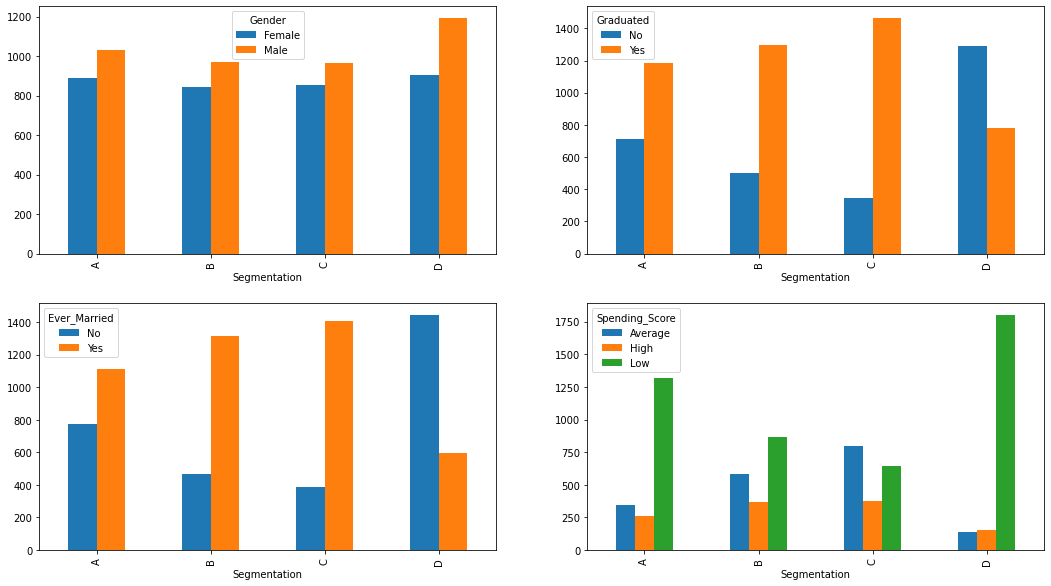

In [ ]:
ax1 = GenderBySegment.value_counts().unstack().round(3)
ax2 = GraduationBySegmentation.value_counts().unstack().round(3)
ax3 = MarriedBySegment.value_counts().unstack().round(3)
ax4 = SpendingBySegment.value_counts().unstack().round(3)

fig, axs = plt.subplots(2,2,figsize=(18,10))
ax1.plot(kind="bar",ax = axs[0][0])
ax2.plot(kind="bar",ax = axs[0][1])
ax3.plot(kind="bar",ax = axs[1][0])
ax4.plot(kind="bar",ax = axs[1][1])

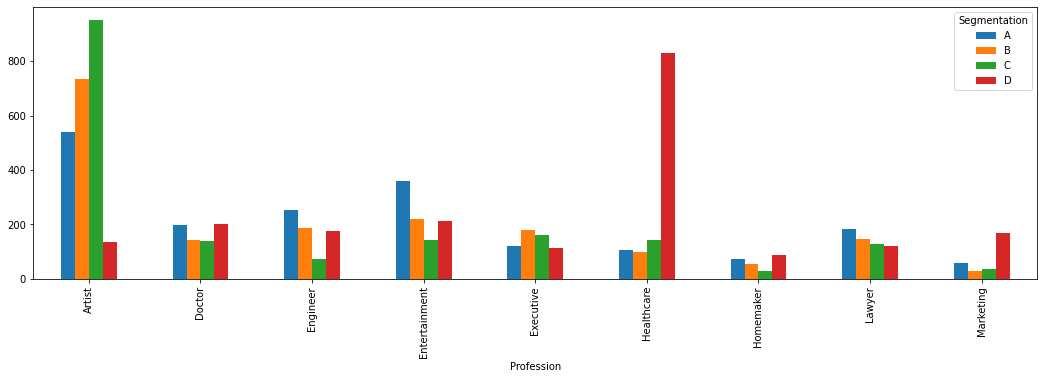

In [ ]:
ax5 = df_train.groupby(["Profession"])["Segmentation"].value_counts().unstack().round(3)
ax5.plot(kind="bar",figsize = (18,5))

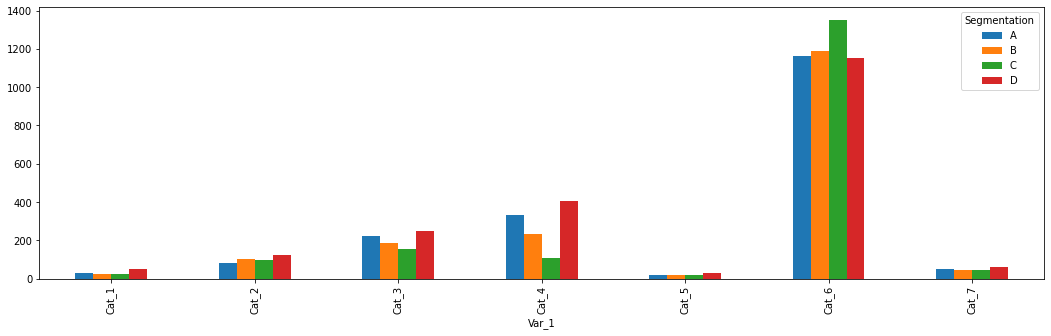

In [ ]:
ax6 = df_train.groupby(["Var_1"])["Segmentation"].value_counts().unstack().round(3)
ax6.plot(kind="bar",figsize = (18,5))

Age
Skewness: 0.707194
Kurtosis: -0.125701
--------------------------------------------------
Work_Experience
Skewness: 1.251954
Kurtosis: 0.378663
--------------------------------------------------
Family_Size
Skewness: 1.027228
Kurtosis: 1.255133
--------------------------------------------------


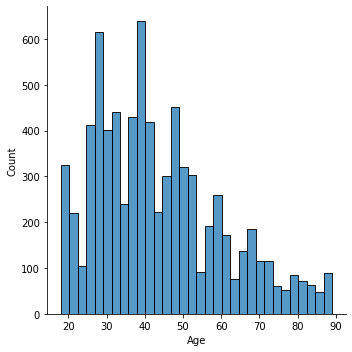

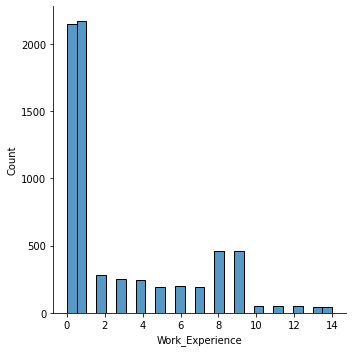

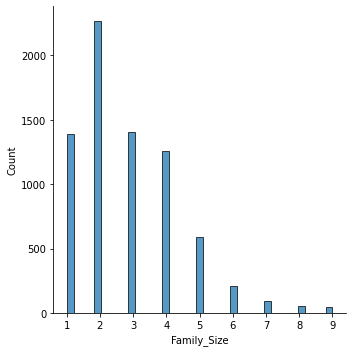

In [ ]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
#Checking for Skew and Kurtosis of Numeric variables
for col in numerical_feats:
    print(col)
    sns.displot(df_train[col]);
    print("Skewness: %f" % df_train[col].skew())
    print("Kurtosis: %f" % df_train[col].kurt())
    print("--"*25)

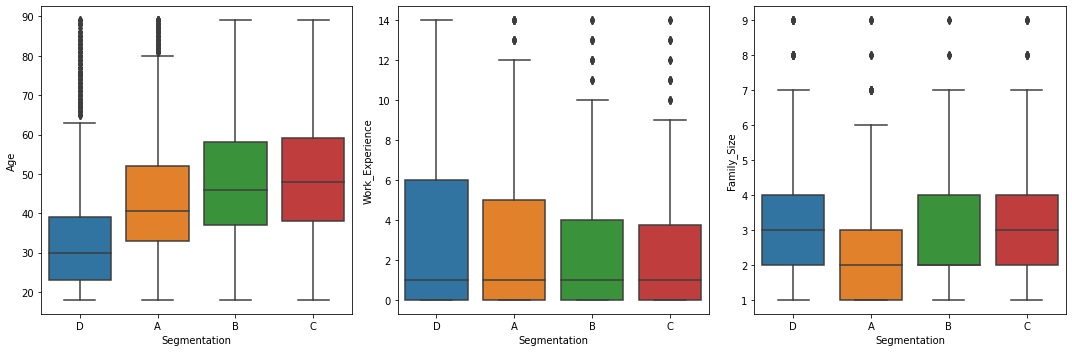

In [ ]:
# Plot to gain insight as numeric indicators vary for every segment user
df_num_feats = list(numerical_feats)

fig, axs = plt.subplots( 1,3, figsize=(15 ,5))

for r in range(0,2):
    for c in range(0,3):  
        i = r*3+c
        if i < len(df_num_feats):
            sns.boxplot(x=df_train['Segmentation'], y=df_num_feats[i], data=df_train, ax = axs[c])
    
plt.tight_layout()    
plt.show() 

**Observations**

*   In each of the segment the count of cat_6 or proportion of cat_6 is very high i.e. most of the entries in the given data belongs to cat_6.
*   All the 4 segments have around same number of male-female distribution. In all segment male are more than female.
But segment D has highest male percentage as compared to other segments.
*  We seen that most of the customers in segment C are married while segment D has least number of married customers. It means segment D is a group of customers that are mostly singles and maybe younger in age.
* The mean age of segment D is 33 and we can say that people in this segment are belong to 30s i.e. they are younger and also from 'ever_married' distribution it is seen that segment D has maximum number of customers who are singles indicating they are younger.
Also segment C has mean age of 49 and we also seen that most cutomers in this segment are married.
* Segment C has most number of customers who are graduated while segment D has lowest number of graduate customers.
* Segment A,B and C have major customers from profession: Artist while Segment D have major customers from profession:Healthcare.
Homemaker is least in all the four segment.
* Segment D has people with relatively more experienced than other segments while Segment C has people with low experience
* Segment D has maximum number of people with low spending score while in Segment C average spending people are more.
* In the given data it is observed that most of the people have family size of 1 or 2 (i.e. they have small family).
But Segment D has more number of big families as compared to other segments.


In [ ]:
df_train.groupby("Profession")['Age'].agg([np.mean,np.median,min,max,pd.Series.mode])

,mean,median,min,max,mode
Profession,,,,,
Artist,46.168220,45.0,18,89,35
Doctor,37.249267,35.0,18,89,32
Engineer,41.801161,40.0,19,81,40
Entertainment,42.968951,41.0,18,89,37
Executive,50.928696,49.0,18,89,53
Healthcare,27.434783,27.0,18,86,22
Homemaker,38.008230,35.0,20,85,26
Lawyer,74.903614,76.0,20,89,68
Marketing,36.900000,33.0,18,89,25


In [ ]:
df_train.groupby("Graduated")['Age'].agg([np.mean,np.median,min,max,pd.Series.mode])

,mean,median,min,max,mode
Graduated,,,,,
No,38.958919,33.0,18,89,22
Yes,46.351958,43.0,18,89,35


In [ ]:
df_train.groupby(['Profession','Graduated'])['Graduated'].count()

Profession     Graduated
Artist         No            293
               Yes          2053
Doctor         No            284
               Yes           393
Engineer       No            379
               Yes           306
Entertainment  No            341
               Yes           581
Executive      No            288
               Yes           282
Healthcare     No            707
               Yes           454
Homemaker      No            103
               Yes           138
Lawyer         No            217
               Yes           352
Marketing      No            172
               Yes           113
Name: Graduated, dtype: int64

In [ ]:
#df['Profession']=df['Profession'].fillna('Others')
#df.groupby(["Segmentation"])["Graduated"].count()
#df.groupby("Segmentation")['Graduated'].agg(pd.Series.mode)

In [ ]:
# Filling the null values of categorical attributes with mode of the segment they belong to 
for catg in categorical_feats:
  for segment in df_train.Segmentation.unique():
    df_train.loc[ (pd.isnull(df_train[catg])) & (df_train['Segmentation'] == segment),catg] = df_train.groupby("Segmentation")[catg].agg(pd.Series.mode).get(segment)


In [ ]:
# theoritically tree types algorithms accept categorical data, but real implementation of DT only accepts continuous variables
# one-hot encoding not done as categorical attributes are not orderable (0/1 can be given to any one gender and have a negetive impact on outcome)
df_train=pd.get_dummies(df_train, columns=["Gender", "Ever_Married","Graduated","Var_1","Profession","Spending_Score"], prefix=["Gender", "Ever_Married","Graduated","Var_1","Profession","Spending_Score"])

# Impute missing values
imputer = KNNImputer()
df_train[df_train.drop(columns = 'Segmentation').columns] = np.round(imputer.fit_transform(df_train.drop(columns = 'Segmentation')))

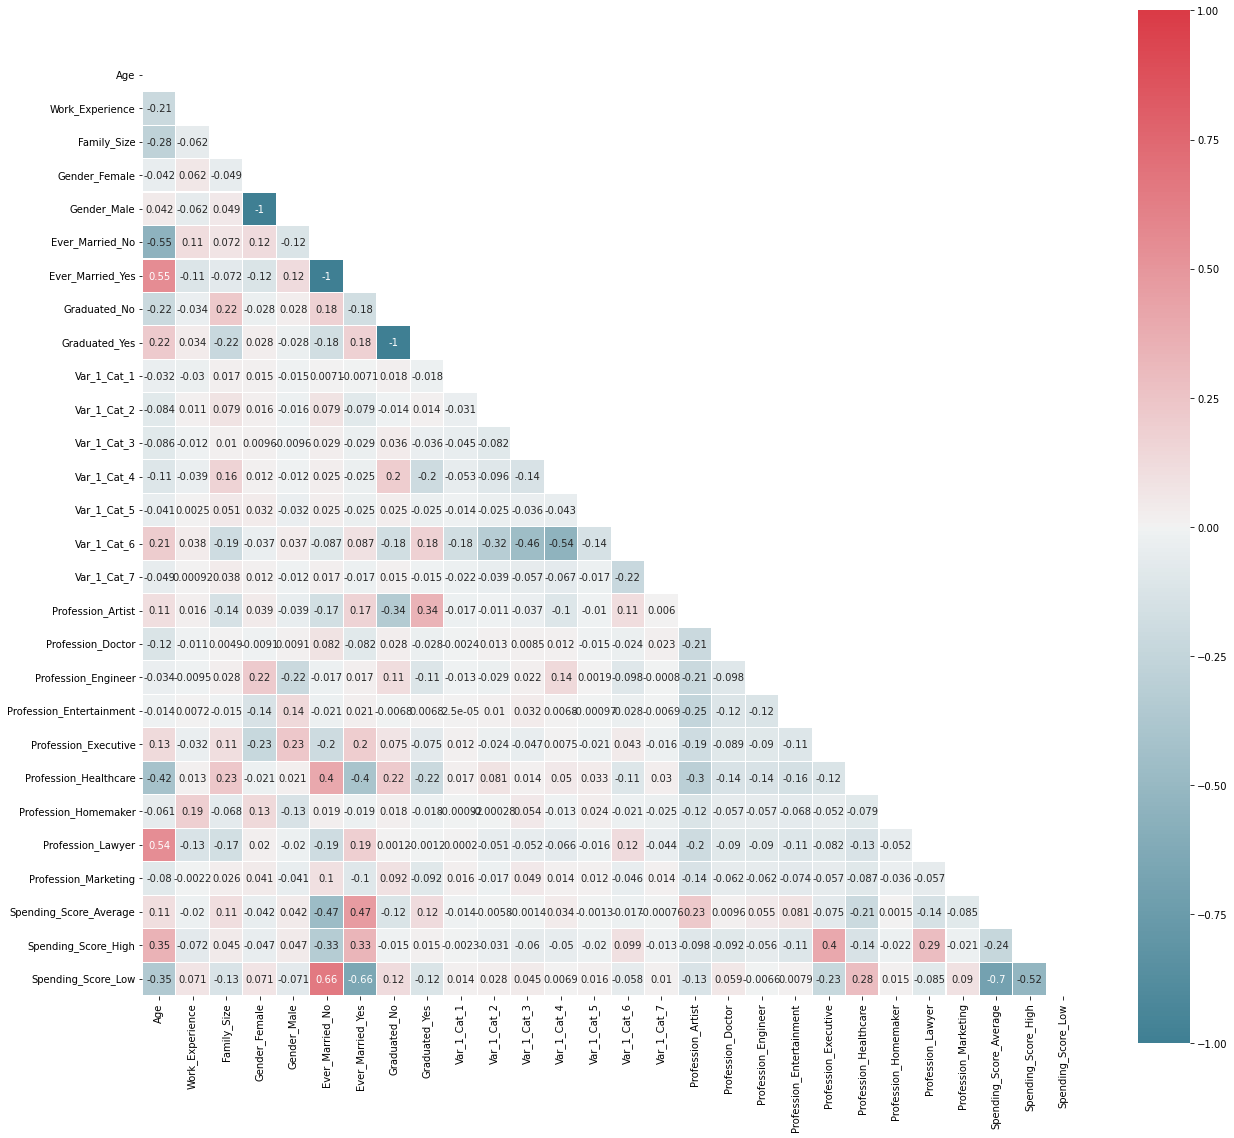

In [ ]:
# plotting co-relation graph to check for inter attribute dependence

numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
li=df_train[numerical_feats]
corr=li.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(21,19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True,
            xticklabels=corr.columns,linewidths=.1,
            yticklabels=corr.columns)

**Observation:**
* ***Age*** and ***Ever_Married*** has a positive correlation of 0.6 which means that people who are married have more age as compared to those who are unmarried.
* ***Age*** and ***Profession_Healthcare*** has a negative correlation of 0.5 which means all those people whose profession is healthcare are younger in age to those who of other professions people.
* ***Profession_Healthcare*** and ***Ever_Married*** has negative correlation of 0.42 which means all those peoples whose profession is healthcare are unmarried.(only 13% of healthcare professionals are married).
* ***Age*** and ***Profession_Lawyer*** has a positive correlation of 0.42 which means all those people whose profession is lawyer are older in age to those of other professions people.
* ***Ever_Married*** and ***Spending_Average*** has a positive correlation which means those who are married spend averagely.(around 42% married people spent averagely)
* ***Ever_Married*** and ***Spending_High*** has a little positive correlation which means those who are married spend high.(around 25% of married people spent high)
* ***Ever_Married*** and ***Spending_Low*** has a negative correlation of 0.67 which means those who are unmarried spent low.(round 99% of unmarried people spent low )
* ***Age*** and ***Spending_Score*** has a positive correlation of 0.42 which means as age increase the spending power also increase.
* ***Profession_Executives*** and ***Spending_High*** has positive correlation of 0.40 which means all those peoples whose profession is executive spent high.(around 66% of executives spent high).

In [ ]:
# Loading the dataset
uploaded = files.upload()

In [ ]:
# importing dataset to dataframe
df_test = pd.read_csv('test.csv')

In [ ]:
X = df_train.copy()
X_test = df_test.copy()

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


In [ ]:
X_test.drop(['ID'], axis = 1, inplace = True)
categorical_feats = X_test.dtypes[X_test.dtypes == "object"].index
for catg in categorical_feats:
    X_test[catg].fillna(X_test[catg].mode()[0], inplace=True)

In [ ]:
X_test=pd.get_dummies(X_test, columns=["Gender", "Ever_Married","Graduated","Var_1","Profession","Spending_Score"], prefix=["Gender", "Ever_Married","Graduated","Var_1","Profession","Spending_Score"])
X_test[X_test.columns] = np.round(imputer.fit_transform(X_test))


In [ ]:
# Spliting our dataframes to train X_train and validation X_valid subsets
X_train, X_valid = train_test_split(X, test_size=.3, random_state=100,stratify=X.Segmentation)
y_train = X_train.pop('Segmentation')
y_valid = X_valid.pop('Segmentation')

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=3, min_samples_leaf= 5 )
# criterion="entropy"
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [ ]:
#Predict the response for test dataset
y_pred_dt = clf.predict(X_valid)

In [ ]:
accuracy_dt = accuracy_score(y_valid, y_pred_dt)
print("DT Accuracy: %.2f%%" % (accuracy_dt * 100.0))
confusion_matrix_dt = confusion_matrix(y_valid, y_pred_dt)
print('-------The confusion matrix for this model is-------')
print(confusion_matrix_dt)
print('\n\n-------Printing the whole report of the model-------')
print(classification_report(y_valid, y_pred_dt))

DT Accuracy: 49.35%
-------The confusion matrix for this model is-------
[[207 212  33 124]
 [ 94 286 104  60]
 [ 48 204 219  76]
 [143  61   4 421]]


-------Printing the whole report of the model-------
              precision    recall  f1-score   support

           A       0.42      0.36      0.39       576
           B       0.37      0.53      0.44       544
           C       0.61      0.40      0.48       547
           D       0.62      0.67      0.64       629

    accuracy                           0.49      2296
   macro avg       0.51      0.49      0.49      2296
weighted avg       0.51      0.49      0.49      2296



In [ ]:
Rf = RandomForestClassifier(
    max_depth=2, 
    random_state=100,
    n_estimators=1000)

Rf.fit(X_train, y_train)
y_pred_rf = Rf.predict(X_valid)

In [ ]:
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print("RF Accuracy: %.2f%%" % (accuracy_rf * 100.0))
confusion_matrix_rf = confusion_matrix(y_valid, y_pred_rf)
print('-------The confusion matrix for this model is-------')
print(confusion_matrix_rf)
print('\n\n-------Printing the whole report of the model-------')
print(classification_report(y_valid, y_pred_rf))

RF Accuracy: 49.00%
-------The confusion matrix for this model is-------
[[209  61 134 172]
 [154  78 241  71]
 [ 59  29 365  94]
 [106  29  21 473]]


-------Printing the whole report of the model-------
              precision    recall  f1-score   support

           A       0.40      0.36      0.38       576
           B       0.40      0.14      0.21       544
           C       0.48      0.67      0.56       547
           D       0.58      0.75      0.66       629

    accuracy                           0.49      2296
   macro avg       0.46      0.48      0.45      2296
weighted avg       0.47      0.49      0.46      2296



In [ ]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5,
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=1, n_estimators=500, n_jobs=4,
              nthread=None, objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False,
              random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=None,
              silent=None, subsample=0.8)


In [ ]:
xgb.fit(X_train, y_train)
y_pred_xg = xgb.predict(X_valid)

In [ ]:
accuracy_xgb = accuracy_score(y_valid, y_pred_xg)
print("Xgb Accuracy: %.2f%%" % (accuracy_xgb * 100.0))
confusion_matrix_xg = confusion_matrix(y_valid, y_pred_xg)
print('-------The confusion matrix for this model is-------')
print(confusion_matrix_xg)
print('\n\n-------Printing the whole report of the model-------')
print(classification_report(y_valid, y_pred_xg))

Xgb Accuracy: 53.22%
-------The confusion matrix for this model is-------
[[256 118  70 132]
 [121 184 169  70]
 [ 55  89 318  85]
 [122  31  12 464]]


-------Printing the whole report of the model-------
              precision    recall  f1-score   support

           A       0.46      0.44      0.45       576
           B       0.44      0.34      0.38       544
           C       0.56      0.58      0.57       547
           D       0.62      0.74      0.67       629

    accuracy                           0.53      2296
   macro avg       0.52      0.53      0.52      2296
weighted avg       0.52      0.53      0.52      2296



In [ ]:
model = LGBMClassifier(num_leaves=11,n_estimators=200)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.516 (0.020)


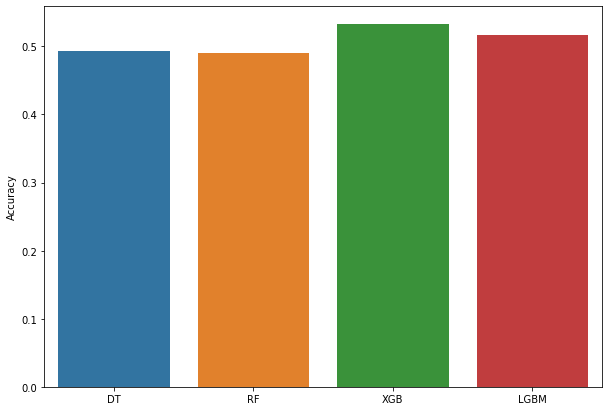

In [ ]:
# Comparing accuracy values for the 4 models 
list_scores = [accuracy_dt, accuracy_rf,accuracy_xgb,np.mean(n_scores)]
list_regressors = ['DT','RF','XGB','LGBM']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('Accuracy')
plt.show()

We see that the XGBoost trees have the maximum accuracy of 54%.We see the metrics for segment D has highest as segments D is highly influenced by Female heathcare workers who are young

In [ ]:
y_test_pred_xg = xgb.predict(X_test)
X_test['Segmentation']=pd.Series(y_test_pred_xg)

In [ ]:
cols2collapse = {
    'Gender': True,
    'Graduated': True,
    'Ever_Married': True,
    'Profession': True,
    'Spending_Score': True,
    'Var_1': True,
    'Age' : False,
    'Work_Experience' : False,
    'Family_Size' : False , 
    'Segmentation' : False
}
# undummify the categorical columns
X_test=undummify(X_test,cols2collapse, prefix_sep="_")

In [ ]:
# append the predicted segment to the test dataframe
df_test['Segmentation']=pd.Series(y_test_pred_xg)
# save the result into a csv file
df_test.to_csv('test_output.csv',index=False)